# Preprocessing and Modelling

In [1]:
# import all libraries here

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer

from scipy import stats

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [2]:
# loading the visualisation dataframe

df_vis = joblib.load('../data/jlib_files/dataframes/complete_df_2_modelling.jlib')

In [3]:
# loading the adapted dataframe for modelling

df = joblib.load('../data/jlib_files/dataframes/modelling_df_2_modelling.jlib')

For the time being, I'm not going to be including any NLP in my model, so I'll drop all of the text variables from my dataframe. I'll then separate the dataset in to predictor (X) and target (y) datasets.

In [4]:
X = df.copy()

y = X.pop('price')

X.drop(['name', 'description', 'neighborhood_overview', 'host_about'], axis=1, inplace=True)

The datasets are then going to be separated in to 80:20 train and test splits to check how the model works on unseen data.

In [5]:
# setting up train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, shuffle=True)

In [6]:
# setting up the pipeline to transform the data

categorical_variables = ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                         'neighbourhood', 'room_type', 'property_type_basic']

# instantiating my transformers

one_hot = OneHotEncoder(sparse=False, drop='first')
scaler = StandardScaler(with_mean=True, with_std=True)

col_trans = ColumnTransformer(
[('dummy', one_hot, categorical_variables)],
remainder='passthrough',
sparse_threshold=0)

## Linear regression with regularisation

### Elastic Net 

In [37]:
model= ElasticNetCV(l1_ratio=[0.00001, 0.001, 0.01, 0.1, 
                               0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     alphas=np.logspace(-5, 5, 100),
                     cv=5, max_iter=100000)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

pipe.fit(X_train,y_train)

# get the best alpha
print('Best alpha:', model.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', model.l1_ratio_)
# evaluate on the training set
print('Training score:', pipe.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", pipe.score(X_test, y_test))

Best alpha: 0.05462277217684343
Best l1-ratio: 1.0
Training score: 0.40785974128134417
Test Score: 0.4250197076556417


### Ridge

In [29]:
model = RidgeCV(np.logspace(-5, 5, 100),cv=5)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

pipe.fit(X_train,y_train)

print('Best alpha:', model.alpha_)
# evaluate on the training set
print('Training score:', pipe.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", pipe.score(X_test, y_test))

Best alpha: 148.49682622544634
Training score: 0.4079254724036224
Test Score: 0.4250804359421917


In [12]:
ridge = Ridge(alpha=148.4968)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', ridge)])

### Lasso

In [30]:
model = LassoCV(alphas=np.logspace(-5, 5, 100),cv=5)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

pipe.fit(X_train,y_train)

print('Best alpha:', model.alpha_)
# evaluate on the training set
print('Training score:', pipe.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", pipe.score(X_test, y_test))

Best alpha: 0.05462277217684343
Training score: 0.40785974128134417
Test Score: 0.4250197076556417


The model seems to perform best with Ridge CV out of the linear regression with regularisation models.

Log Transform the price variable to improve the results of the linear regression models.

### Decision Tree Regressor

In [15]:
decision_tree = DecisionTreeRegressor()

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('decision_tree', decision_tree)])

In [16]:
params = {'decision_tree__max_depth': range(3,11),
         'decision_tree__min_samples_split': [2,10,30,50],
         'decision_tree__min_samples_leaf': [1,5,10,30,50],
         'decision_tree__max_features': ['auto', 0.8, 0.5, 'sqrt']}

In [17]:
gs_decision_tree = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=2)

In [18]:
gs_decision_tree.fit(X_train,y_train)

print("Training Score: {}".format(gs_decision_tree.score(X_train,y_train)))
print("Test Score: {}".format(gs_decision_tree.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_decision_tree.best_score_))
print("Best Model Parameters: {}".format(gs_decision_tree.best_params_))

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 1444 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 1971 tasks      | elapsed:  3.0min
/Users/jamesradford/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done 2578 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-2)]: Done 3200 out of 3200 | elapsed:  5.3min finished


Training Score: 0.6150027637205997
Test Score: 0.5203279899867976
CV Mean Score: 0.5083160479382611
Best Model Parameters: {'decision_tree__max_depth': 10, 'decision_tree__max_features': 0.8, 'decision_tree__min_samples_leaf': 5, 'decision_tree__min_samples_split': 30}


### Random Forest Regressor

In [71]:
random_forest = RandomForestRegressor(n_jobs=-2,random_state=1, verbose=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

params = {'random_forest__n_estimators': [100, 150],
         'random_forest__max_depth': [None, 10, 50],
         'random_forest__min_samples_leaf': [1,5,30],
         'random_forest__max_features': ['auto', 0.8],
         'random_forest__max_samples': [None, 0.8],
         'random_forest__ccp_alpha': [0, 0.005, 0.01]}

gs_random_forest = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=2)

In [74]:
gs_random_forest.fit(X_train,y_train)

print("Training Score: {}".format(gs_random_forest.score(X_train,y_train)))
print("Test Score: {}".format(gs_random_forest.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_random_forest.best_score_))
print("Best Model Parameters: {}".format(gs_random_forest.best_params_))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed: 105.2min
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed: 191.9min
[Parallel(n_jobs=-2)]: Done 1080 out of 1080 | elapsed: 213.4min finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:  1.5min finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s


Training Score: 0.9459556960470796
Test Score: 0.6291665344653148
CV Mean Score: 0.6107639031987422
Best Model Parameters: {'random_forest__ccp_alpha': 0.005, 'random_forest__max_depth': None, 'random_forest__max_features': 0.8, 'random_forest__max_samples': None, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 150}


[Parallel(n_jobs=7)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 150 out of 150 | elapsed:    0.1s finished


In [79]:
# saving the pipeline and best estimator

# joblib.dump(pipe,'../data/jlib_files/pipe_random_forest_1')
# joblib.dump(gs_random_forest.best_estimator_,'../data/jlib_files/model_random_forest_1')

['../data/jlib_files/model_random_forest_1']

### Gradient Boosting Regressor

In [92]:
gradient_boosting = GradientBoostingRegressor(random_state=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('gradient_boosting', gradient_boosting)])

params = {'gradient_boosting__n_estimators': [100,150],
         'gradient_boosting__subsample': [0.8, 1],
         'gradient_boosting__min_samples_split': [2,15,30],
         'gradient_boosting__min_samples_leaf': [1, 5],
         'gradient_boosting__max_depth': [3, 5, 10],
         'gradient_boosting__max_features': ['auto', 'sqrt'],
         'gradient_boosting__ccp_alpha': [0, 0.005, 0.01]
         }

gs_grad_boost = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=1)

In [93]:
gs_grad_boost.fit(X_train,y_train)

print("Training Score: {}".format(gs_grad_boost.score(X_train,y_train)))
print("Test Score: {}".format(gs_grad_boost.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_grad_boost.best_score_))
print("Best Model Parameters: {}".format(gs_grad_boost.best_params_))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
/Users/jamesradford/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 68.0min
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed: 101.4min
[Parallel(n_jobs=-2)]: Done 1786 tasks      | elapsed: 149.3min
[Parallel(n_jobs=-2)]: Done 2160 out of 2160 | elapsed: 184.6min finished


Training Score: 0.893968414648733
Test Score: 0.6262948839118985
CV Mean Score: 0.6134737528844415
Best Model Parameters: {'gradient_boosting__ccp_alpha': 0, 'gradient_boosting__max_depth': 10, 'gradient_boosting__max_features': 'sqrt', 'gradient_boosting__min_samples_leaf': 1, 'gradient_boosting__min_samples_split': 2, 'gradient_boosting__n_estimators': 150, 'gradient_boosting__subsample': 1}


In [94]:
# saving the pipeline and best estimator

# joblib.dump(pipe,'../data/jlib_files/pipe_gradient_boosting_1')
# joblib.dump(gs_grad_boost.best_estimator_,'../data/jlib_files/model_gradient_boosting_1')

['../data/jlib_files/model_gradient_boosting_1']

### Bagging Regressor

In [26]:
bagging_regressor = BaggingRegressor(n_jobs=-2)

ridge = Ridge(alpha=148.4968)
decision_tree = DecisionTreeRegressor(max_depth = 10, max_features = 0.8, min_samples_leaf = 5,
                                      min_samples_split = 30)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('br', bagging_regressor)])

params = {'br__base_estimator': [ridge, decision_tree],
         'br__n_estimators': [20, 60, 120],
         'br__max_samples': [0.5, 0.8, 1.0, 1.2],
         'br__max_features': [0.5, 0.8, 1.0, 1.2],
         'br__bootstrap': [True, False]}

gs_bag_regressor = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=1)

In [27]:
gs_bag_regressor.fit(X_train,y_train)

print("Training Score: {}".format(gs_bag_regressor.score(X_train,y_train)))
print("Test Score: {}".format(gs_bag_regressor.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_bag_regressor.best_score_))
print("Best Model Parameters: {}".format(gs_bag_regressor.best_params_))

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-2)]: Done 960 out of 960 | elapsed: 31.7min finished


Training Score: 0.6625696822099179
Test Score: 0.5939912759681434
CV Mean Score: 0.5784979996168834
Best Model Parameters: {'br__base_estimator': DecisionTreeRegressor(max_depth=10, max_features=0.8, min_samples_leaf=5,
                      min_samples_split=30), 'br__bootstrap': False, 'br__max_features': 0.8, 'br__max_samples': 1.0, 'br__n_estimators': 60}


# Analyse the results of the gradient boosting regressor

In [7]:
grad_boost = joblib.load("../data/jlib_files/models/model_gradient_boosting_1")
grad_boost.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('dummy',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['host_response_time',
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'neighbourhood', 'room_type',
                                                   'property_type_basic'])])),
                ('scaler', StandardScaler()),
                ('gradient_boosting',
                 GradientBoostingRegressor(ccp_alpha=0, max_depth=10,
                                           max_features='sqrt',
                                           n_estimators=150, random_state=1

In [59]:
# combining train and test sets and adding the predictions

predictions_train = grad_boost.predict(X_train)
predictions_test = grad_boost.predict(X_test)

train_vis = X_train.copy()
test_vis = X_test.copy()

train_vis['price_true'] = y_train
test_vis['price_true'] = y_test

train_vis['price_pred'] = predictions_train
test_vis['price_pred'] = predictions_test

train_vis['residuals'] = train_vis.price_true - train_vis.price_pred
test_vis['residuals'] = test_vis.price_true - test_vis.price_pred

train_vis['residuals_abs'] = abs(train_vis.residuals)
test_vis['residuals_abs'] = abs(test_vis.residuals)

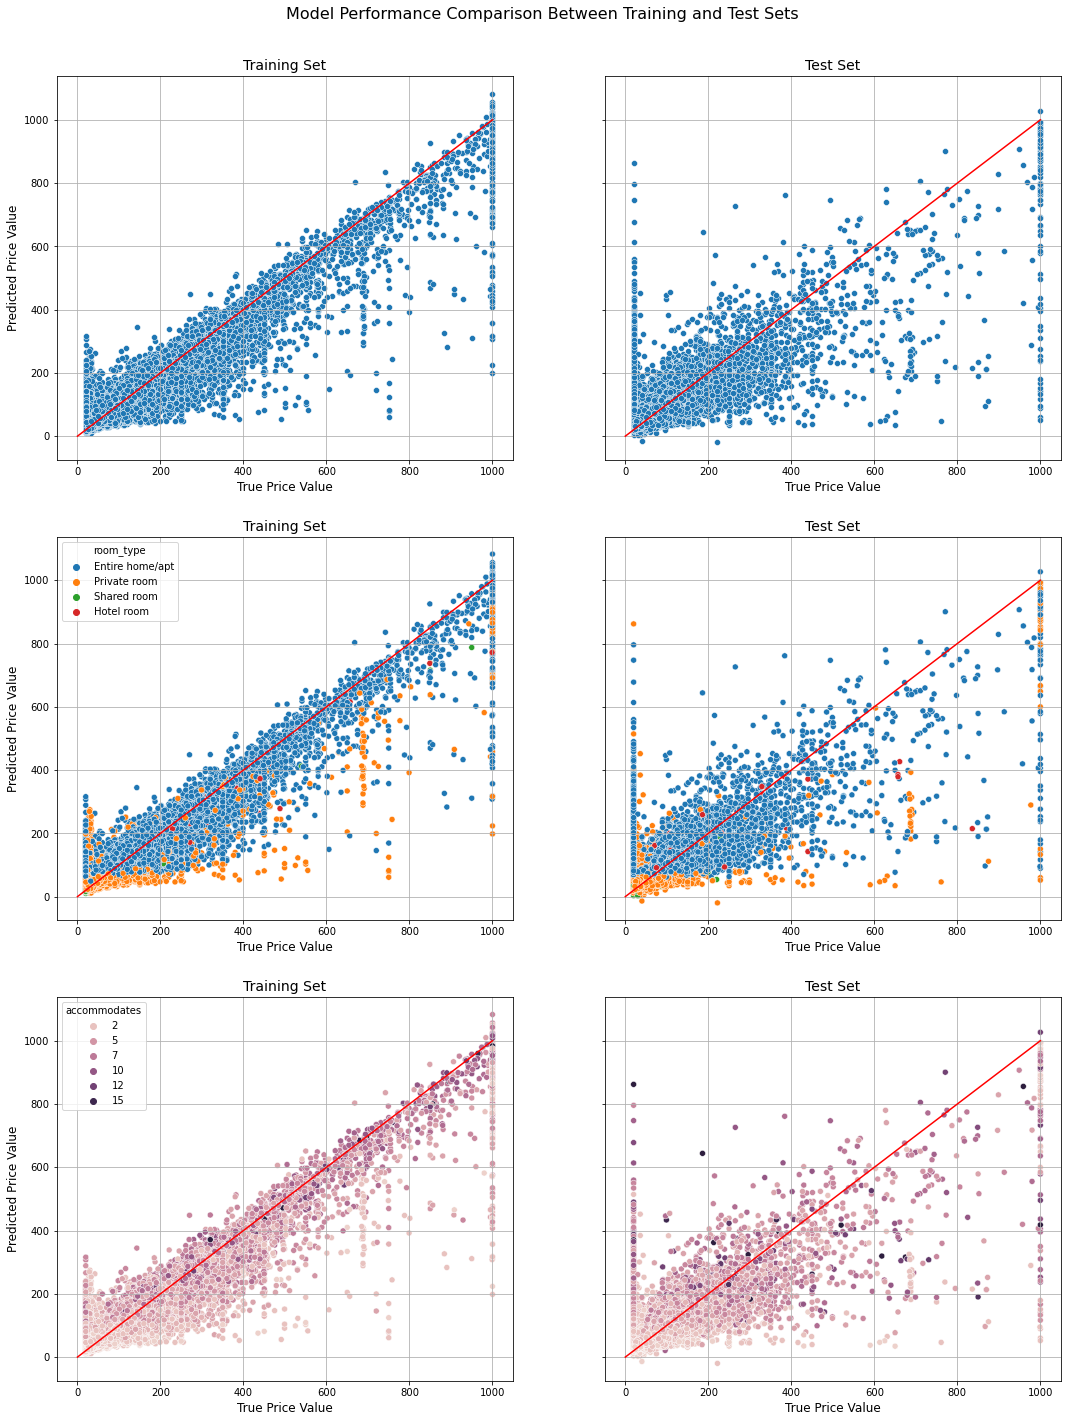

In [108]:
fig, ax = plt.subplots(3,2,figsize=(18,24), sharey=True)

for ax_tuple, variable in zip(enumerate(ax.flatten()),[None, None, 'room_type','room_type', 'accommodates', 'accommodates']):
    
    if ax_tuple[0]%2==0:
        sns.scatterplot(x = 'price_true', y = 'price_pred', hue = variable, data = train_vis, ax=ax_tuple[1])
        ax_tuple[1].set_title('Training Set', fontsize=14)
    else:    
        sns.scatterplot(x = 'price_true', y = 'price_pred', hue = variable, data = test_vis, ax=ax_tuple[1],
                       legend=False)
        ax_tuple[1].set_title('Test Set', fontsize=14)

    ax_tuple[1].grid()
    ax_tuple[1].set_xlabel('True Price Value', fontsize=12)
    ax_tuple[1].set_ylabel('Predicted Price Value', fontsize=12)

    ax_tuple[1].plot([0, df.price.max()], [0, df.price.max()], lw=1.5, c='r')

plt.suptitle('Model Performance Comparison Between Training and Test Sets', fontsize=16, y=0.92)
plt.show()

Why has the model predicted minus values in the test set?

In [9]:
test_df = X_test.copy()
test_df['true_price'] = y_test
test_df['predicted_price'] = predictions_test

In [109]:
test_df[test_df.predicted_price < 0]

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,room_type,accommodates,bathrooms,...,mean_monthly_rent,serviced_property,description_provided,host_about_provided,name_length,description_length,neighborhood_overview_length,host_about_length,true_price,predicted_price
3896,within an hour,Above or equal to 75%,Above or equal to 75%,0,1,1,Croydon,Private room,1,1.0,...,1371.0,0,1,1,5,163,75,182,40.0,-13.863915
37796,within an hour,Above or equal to 75%,Below 75% or not displayed,1,1,1,Hackney,Private room,2,1.0,...,1437.0,0,1,0,7,97,100,0,222.0,-19.824656


In [125]:
p_room_residuals = test_vis[(test_vis.room_type=='Private room')&(test_vis.residuals_abs >50)]

In [110]:
feature_names = grad_boost.named_steps['col_trans'].get_feature_names()
feature_importances = grad_boost.named_steps['gradient_boosting'].feature_importances_

feature_df = pd.DataFrame({'feature_importance': feature_importances},index=feature_names)

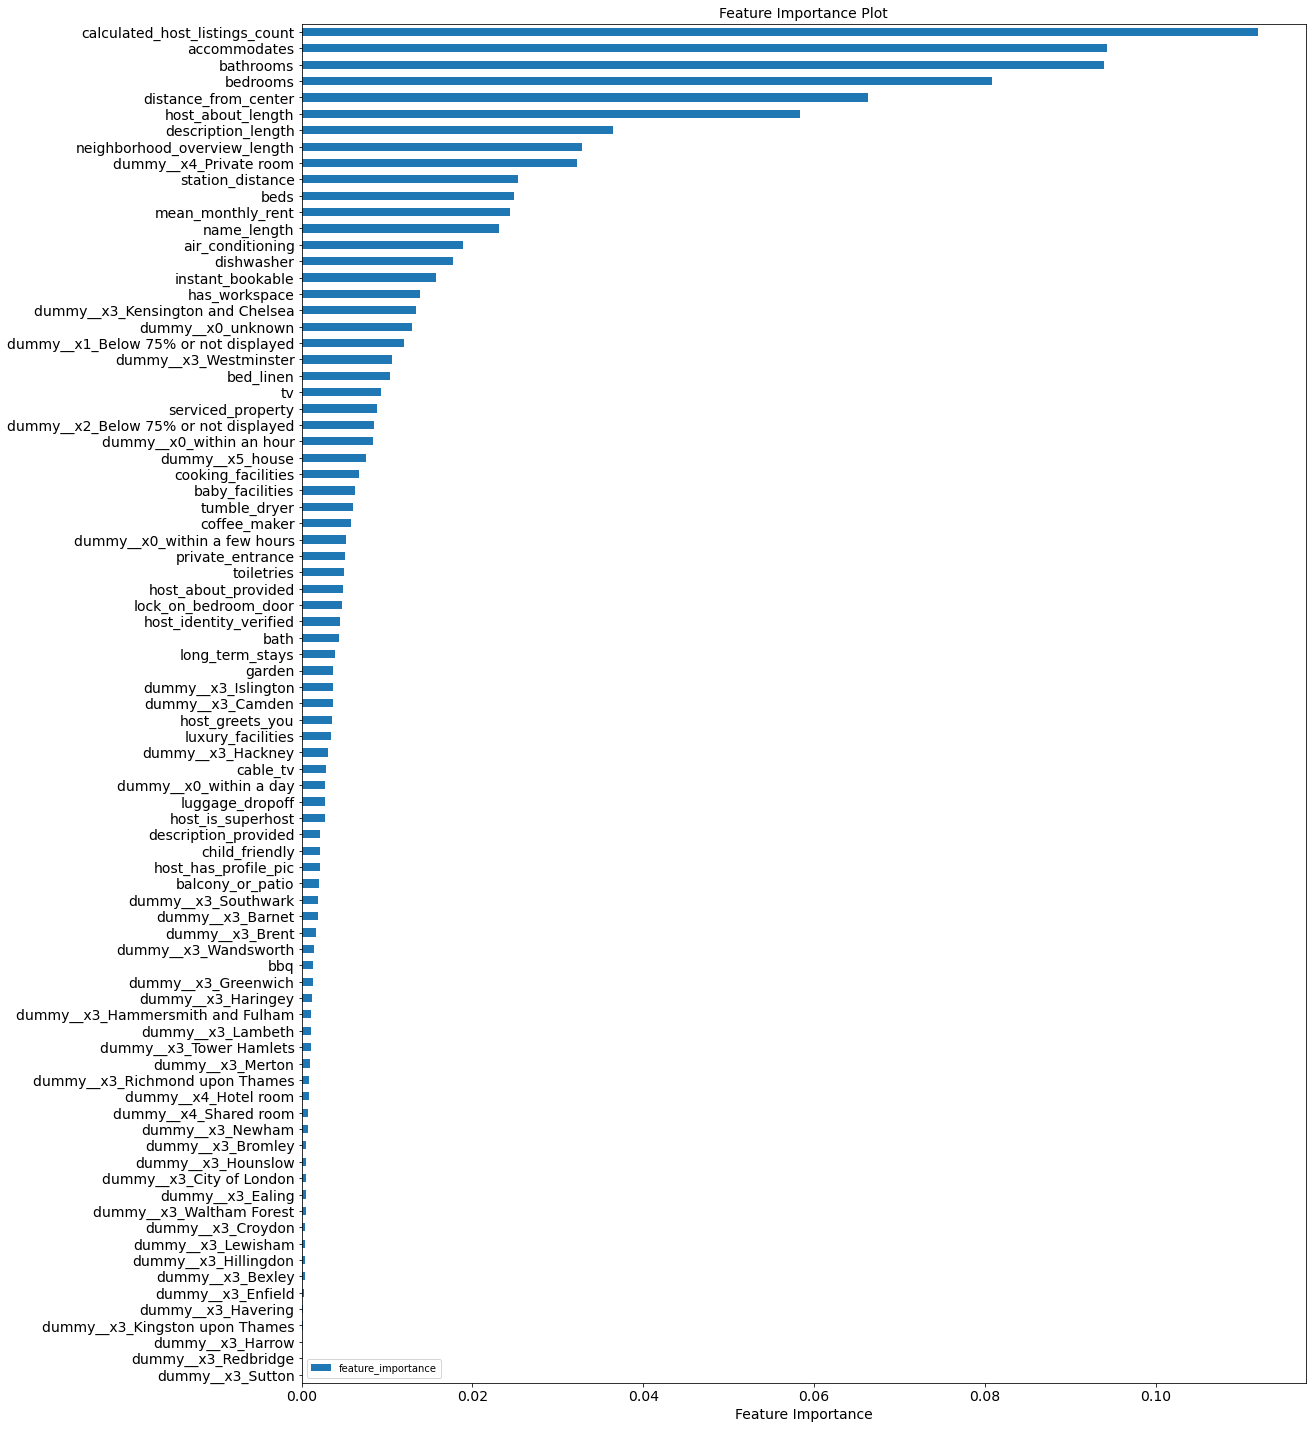

In [111]:
fig,ax = plt.subplots(figsize=(18,25))

feature_df.sort_values('feature_importance').plot.barh(ax=ax,fontsize=14)

ax.set_title('Feature Importance Plot', fontsize=(14))
ax.set_xlabel('Feature Importance', fontsize=(14))

plt.show()

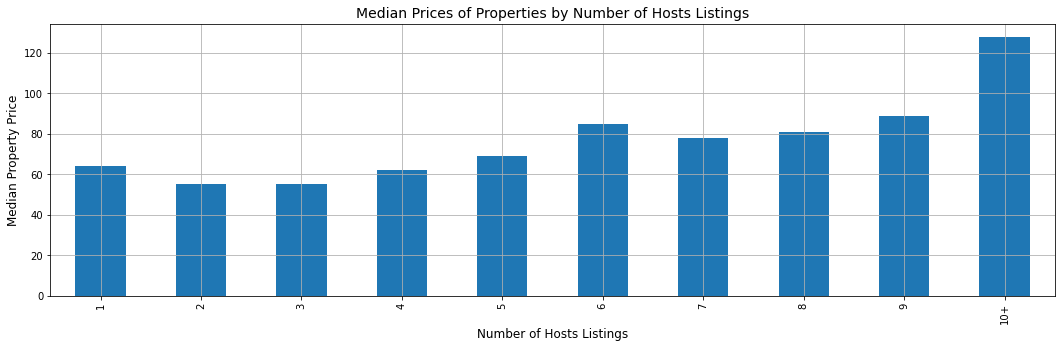

In [112]:
df_vis['host_listings_obj'] = df_vis.calculated_host_listings_count.apply(lambda x: "10+" if x>= 10 else x)

fig,ax=plt.subplots(figsize=(18,5))

df_vis.groupby('host_listings_obj').median()['price'].plot.bar(ax=ax, grid=True)

ax.set_title('Median Prices of Properties by Number of Hosts Listings', fontsize=14)
ax.set_xlabel('Number of Hosts Listings', fontsize=12)
ax.set_ylabel('Median Property Price', fontsize=12)

plt.show()